In [3]:
#데이터 시각화 및 핸들링
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import Image
from sklearn.model_selection import train_test_split
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50 
import tensorflow as tf

In [4]:
path = "./AutismDataset/consolidated"

In [5]:
Autistic_Data = os.listdir("./AutismDataset/consolidated/Autistic")
Non_Autistic_Data = os.listdir("./AutismDataset/consolidated/Non_Autistic")

In [6]:
DataPath = {"Path":list(map(lambda x: path + "/Autistic/" + x ,Autistic_Data)) + list(map(lambda x: path + f"/Non_Autistic/" + x ,Non_Autistic_Data))}
df = pd.DataFrame(DataPath)
df["Label"] = df["Path"].apply(lambda x : 1 if x.split("/")[-2] == "Autistic" else 0)
df

,Path,Label
0,./AutismDataset/consolidated/Autistic/0071.jpg,1
1,./AutismDataset/consolidated/Autistic/0717.jpg,1
2,./AutismDataset/consolidated/Autistic/1409.jpg,1
3,./AutismDataset/consolidated/Autistic/0703.jpg,1
4,./AutismDataset/consolidated/Autistic/0065.jpg,1
...,...,...
2935,./AutismDataset/consolidated/Non_Autistic/1362...,0
2936,./AutismDataset/consolidated/Non_Autistic/1404...,0
2937,./AutismDataset/consolidated/Non_Autistic/1410...,0
2938,./AutismDataset/consolidated/Non_Autistic/0068...,0


각 레이블 별로 예시 데이터 시각화

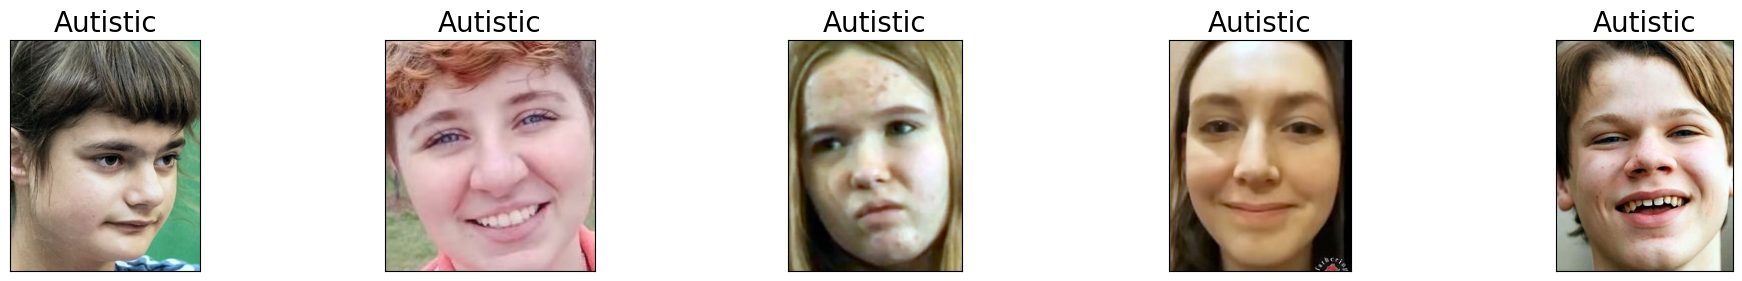

In [7]:
plt.figure(figsize=(24,3))
for i in range(5):
  plt.subplot(1,5,i+1)
  img = np.asarray(Image.open(df["Path"][i]))
  plt.imshow(img)
  plt.xticks([]); plt.yticks([])
  plt.title( "Autistic" if str(df["Label"][i]) else "None_Autistic", fontsize=20)

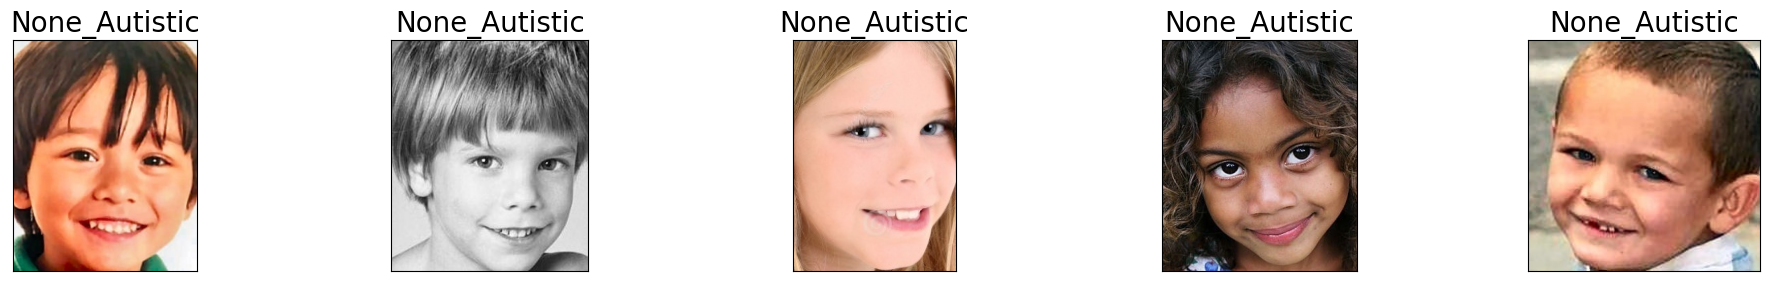

In [8]:
plt.figure(figsize=(24,3))
for idx, i in enumerate(df[df["Label"]==0].head().Path):
  plt.subplot(1,5,idx+1)
  img = np.asarray(Image.open(i))
  plt.imshow(img)
  plt.xticks([]); plt.yticks([])
  plt.title( "None_Autistic", fontsize=20)

전체 데이터 갯수

In [9]:
len(Autistic_Data) + len(Non_Autistic_Data)

2940

In [14]:
img = cv2.imread(df["Path"][1])

image resizing

(224, 204, 3)

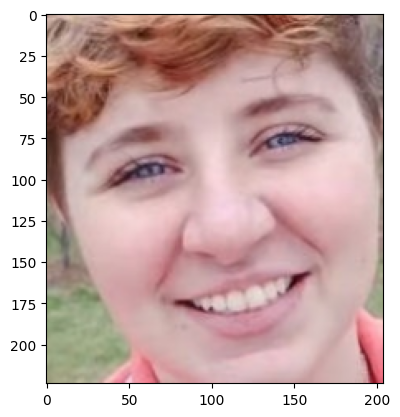

In [15]:
# 이미지의 width와 height 중 긴 쪽을 img_size에 맞추기
img_size = 224

if(img.shape[1] > img.shape[0]) : 
    ratio = img_size/img.shape[1]
else :
    ratio = img_size/img.shape[0]

img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

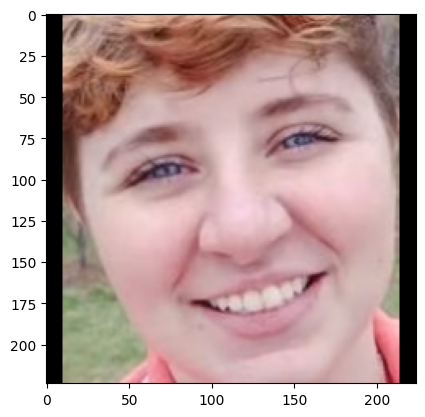

In [16]:
# 그림 주변에 검은색으로 칠하기
w, h = img.shape[1], img.shape[0]

dw = (img_size-w)/2 # img_size와 w의 차이
dh = (img_size-h)/2 # img_size와 h의 차이

M = np.float32([[1,0,dw], [0,1,dh]])  #(2*3 이차원 행렬)
img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환  

plt.imshow(cv2.cvtColor(img_re, cv2.COLOR_BGR2RGB))

face alignment

In [13]:
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def shape_to_normal(shape):
    shape_normal = []
    for i in range(0, 5):
        shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
    return shape_normal
def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def cosine_formula(length_line1, length_line2, length_line3):
    cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
    return cos_a

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

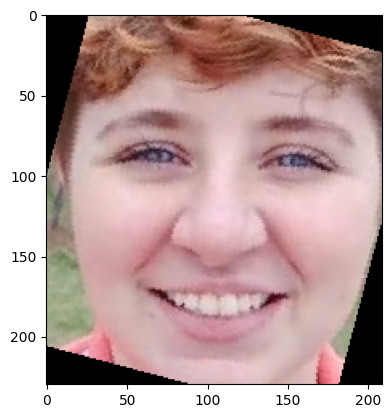

In [18]:

img = cv2.imread(df["Path"][1])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)
if len(rects) > 0:
	for rect in rects:
		x = rect.left()
		y = rect.top()
		w = rect.right()
		h = rect.bottom()
		shape = predictor(gray, rect)

#세은 추가 코드 -> 오류나면 이것부터 확인해보기 
if type(shape) != list :
	shape = shape_to_normal(shape)

nose, left_eye, right_eye = get_eyes_nose_dlib(shape)

center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

center_pred = (int((x + w) / 2), int((y + y) / 2))

length_line1 = distance(center_of_forehead, nose)
length_line2 = distance(center_pred, nose)
length_line3 = distance(center_pred, center_of_forehead)

cos_a = cosine_formula(length_line1, length_line2, length_line3)
angle = np.arccos(cos_a)

rotated_point = rotate_point(nose, center_of_forehead, angle)
rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
if is_between(nose, center_of_forehead, center_pred, rotated_point):
	angle = np.degrees(-angle)
else:
	angle = np.degrees(angle)

img = Image.fromarray(img)
img = np.array(img.rotate(angle))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

remove noise and Normalize

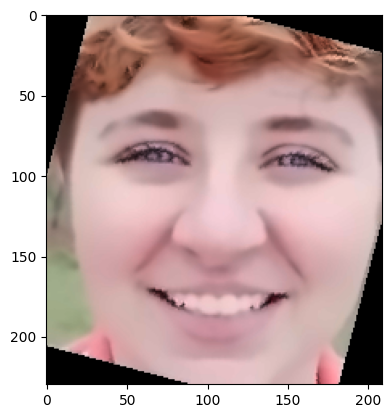

In [19]:
denoised_image = cv2.fastNlMeansDenoisingColored(img, None, 7, 7, 5, 20)
Denoised_Normalized_Image = cv2.normalize(denoised_image, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(cv2.cvtColor(Denoised_Normalized_Image, cv2.COLOR_BGR2RGB))